In [99]:
# Modules

import numpy as np
import numpy.matlib
import time
import scipy.io as sio
from scipy.spatial import cKDTree as ckd

In [100]:
def tic():
    #Homemade version of matlab tic and toc functions
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is {} seconds.".format(str(time.time() - startTime_for_tictoc)))
    else:
        print("Toc: start time not set")

In [101]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [156]:
glacier = 'H'   #pick the glacier you want to construct the seeding for

if glacier == 'H':
    # Helheim Ice Sheet Seeding Locations ---------------------------------
    Glac_Y = np.arange(259,262,1)  #[261,190] 66.3500 N, 38.2000 W coord, Helheim
    Glac_X = np.arange(188,192,1) 
    glac_name = 'Helheim'

elif glacier == 'J':
    # Jakobshaven Ice Sheet Seeding Locations -----------------------------
    Glac_Y = np.arange(276,280,1)  #[277,120] 69 10 N 49 50 W coord, Jakobshavn
    Glac_X = np.arange(119,123,1) 
    glac_name = 'Jakobsh'

elif glacier == 'K':
    # Kangerd Ice Sheet Seeding Locations ---------------------------------
    Glac_Y = np.arange(267,271,1)  #[277,120] 68 38 N 33 0 W coord, Kangerd
    Glac_X = np.arange(213,218,1) 
    glac_name = 'Kangerd'

elif glacier == 'L': 
    # Laurentide Ice Sheet Seeding Locations ------------------------------
    Glac_Y = np.arange(245,255,2)  #Laurentide LAT seed locations (in ECCO 2 grid)
    Glac_X = np.arange(86,101,2)    #Laurentide LON seed locations (in ECCO 2 grid)
    glac_name = 'Laurent' 

#seed_LAT = [LAT[Glac_Y[0]]*[1, 1], LAT[Glac_Y[-1]]*[1, 1]] 
#seed_LON = np.matlib.repmat([LON[Glac_X[0]], LON[Glac_X[-1]]],[2,1]) 
#seed_LAT = np.matlib.repmat([LAT[Glac_Y[0]], LAT[Glac_Y[-1]]],[2,1]) 
#seed_LON = [LON[Glac_X[0]]*[1, 1], LON[Glac_X[-1]]*[1, 1]] 
Seed_Y, Seed_X = np.meshgrid(Glac_Y, Glac_X)

In [102]:
def a(U):
    # \alpha in the paper
    a = np.multiply(np.divide(np.sqrt(2),np.power(U, 3)),(1-np.sqrt(1+np.power(U,4))))
    return a

def b(U):
    # \beta in the paper
    #print(np.multiply((4+np.power(U,4)),np.sqrt(1+np.power(U,4)))-3*np.power(U,4)-4)
    b = np.real(np.multiply(np.divide(1,np.power(U,3)),np.sqrt(np.multiply((4+np.power(U,4)), \
                                            np.sqrt(1+np.power(U,4)))-3*np.power(U,4)-4)))
    
    if not b >= 0:
        b = 0
    
    return b

def ff(lati):
    # Latitude in degrees
    ff = 2*om*np.sin(abs(lati)*np.pi/180)
    return ff

def S(l, w):
    # Harmonic mean length
    S = np.pi*(np.multiply(l, np.divide(w,(l+w))))
    return S

def Ut(u, lati, S):
    # \Lambda in the papers
    Ut = np.sqrt(2)*Cw*g/ff(lati)*u/S
    return Ut

In [103]:
a(1.5)  # agrees with MATLAB

-0.61270622427346211

In [104]:
b(1.5)  # agrees with MATLAB

array(0.523893282859223)

In [105]:
ff(60)  # agrees with MATLAB

0.00012630287693873009

In [106]:
S(1500,1000)  # agrees with MATLAB

1884.9555921538758

In [107]:
Ut(7.6,60,1885)  # agrees with MATLAB

0.76169217656676025

In [ ]:
# Analytic Parameters
R = 6378 * 1e3  ## earth radius in m
rhow = 1027  ## density of water (kg/m^3)
rhoa = 1.2  ## density of air   (kg/m^3)
rhoi = 850  ## density of ice   (kg/m^3)
drho = rhow - rhoi
Cw = 0.9  ## bulk coefficient water  (Bigg et al 1997)
Ca = 1.3  ## bulk coefficient air    (Bigg et al 1997)
om = 7.2921 * 1e-5  ## rotation rate of earth (rad/s)
g = np.sqrt(rhoa*drho/rhow/rhoi*(Ca / Cw))  ## gamma = np.sqrt(ca/cw)
#g = 0.0187

# Melt parameters

Ti0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2



# Set directories

modelfull = 'ECCO_20th'
modelshort = 'E2'
root = '/home/evankielley/WagnerModel'
condloc = root + '/conditions/' + modelfull + '/'
outloc = root + '/output/' + modelfull + '/'
modelloc = root + '/Model/'

# Set run parameters 

trajnum = 25            # total number of iceberg trajectories to compute
final_t = 122           # number of input field time steps
startrange = final_t / 2  # input field start range
tres = 3                # time resoln such that "model Dt"="input DT"/tres
DT = 3                  # Input fields time step
Dt = DT / tres            # model timestep in days
dt = Dt * 24 * 3600         # model timestep in seconds
R = 6378 * 1e3            # earth radius in m
dtR = dt / R * 180 / np.pi       # need this ratio for distances in "drifting.m"
t = np.arange(0, final_t)      # how long is the run
nt = (t.size) * tres             # number of model timesteps
tt = np.linspace(1, t.size, nt) # model time

In [155]:
# Load input fields

tic()
msk = sio.loadmat(condloc + 'mask.mat'); msk = msk['msk'] 
vel = sio.loadmat(condloc + modelshort + '_vels_1992.mat'); vel = vel['vel']
sst = sio.loadmat(condloc + modelshort +'_sst_1992.mat'); sst = sst['sst']
bergdims = sio.loadmat(modelloc + 'bergdims.mat'); bergdims = bergdims['bergdims']
print('Model data loaded \n')
toc()



# Load Seeding fields
Laurent_Seed = sio.loadmat(modelloc + 'Laurent_Seed.mat')
Seed_X = Laurent_Seed['Seed_X']; Seed_Y = Laurent_Seed['Seed_Y']
# Cycle through each location 100x (i.e. this can run 3600 icebergs)
seed_X = np.matlib.repmat(Seed_X, 1, 100); seed_Y = np.matlib.repmat(Seed_Y, 1, 100)
seed_X = seed_X.transpose().flatten(); seed_Y = seed_Y.transpose().flatten()
#seed_X = np.tile(np.ravel(Seed_X), [1, 100]); seed_Y = np.tile(np.ravel(Seed_Y), [1, 100])
#seed_X = seed_X.transpose(); seed_Y = seed_Y.transpose()
#seed_X = np.ravel(seed_X); seed_Y = np.ravel(seed_Y)
print('Fields seeded \n')



# Specify the space domain

LAT = vel['latw'] * 1.0 
LAT = LAT[0,0]
LAT = np.ravel(LAT)
#print(LAT)
LON = vel['lonw'] * 1.0
LON = LON[0,0]
LON = np.ravel(LON)
minLAT = min(LAT[:]) 
maxLAT = max(LAT[:])
minLON = min(LON[:]) 
maxLON = max(LON[:])
print('Space domain specified \n')


# Set the circulation fields

uwF = vel['uw']; vwF = vel['vw']
uwF = uwF[0,0]; vwF = vwF[0,0]
uaF = vel['ua']; vaF = vel['va']  
uaF = uaF[0,0]; vaF = vaF[0,0]
sst = sst[:,:,t]     
print('Circulation fields set \n')

Model data loaded 

Elapsed time is 3.842700958251953 seconds.
Fields seeded 

Space domain specified 

Circulation fields set 



In [159]:
LON.shape

(340,)

In [149]:
seed_Y

array([245, 245, 245, ..., 255, 255, 255], dtype=uint8)

In [109]:
nt

366

In [ ]:
np.linspace(1, 122, 366)

In [173]:
### ICEBERG SHELL ###

banana = sio.loadmat('/home/evankielley/WagnerModel/output/ECCO_20th/banana.mat')
banana = banana['banana']
ts1 = banana[:,0]
randoX1 = banana[:,1]
randoY1 = banana[:,2]

# Loop over individual initial iceberg size classes
bvec = np.arange(1,11)  # vector of which size classes to compute - has to be [1,10]

for bb in bvec:
    bergsize = bb - 1   # current berg size class
    print('run bergsize B{} \n'.format(bergsize + 1))
    
    # Set output arrays    
    XIL = np.empty((trajnum, nt)); XIL[:] = np.NAN; YIL = np.empty((trajnum, nt)); YIL[:] = np.NAN
    VOL = np.empty((trajnum, nt)); VOL[:] = np.NAN; DVOL = np.empty((trajnum, nt)); DVOL[:] = np.NAN
    UI = np.empty((trajnum, nt)); UI[:] = np.NAN; UA = np.empty((trajnum, nt)); UA[:] = np.NAN
    UW = np.empty((trajnum, nt)); UW[:] = np.NAN; VI = np.empty((trajnum, nt)); VI[:] = np.NAN
    VA = np.empty((trajnum, nt)); VA[:] = np.NAN; VW = np.empty((trajnum, nt)); VW[:] = np.NAN        
    TE = np.empty((trajnum, nt)); TE[:] = np.NAN; Memat = np.empty((trajnum, nt)); Memat[:] = np.NAN
    Mvmat = np.empty((trajnum, nt)); Mvmat[:] = np.NAN; Mbmat = np.empty((trajnum, nt)); Mbmat[:] = np.NAN        
    
    # Initialize the iceberg
    L = bergdims[bergsize,0]; W = bergdims[bergsize,1]; H = bergdims[bergsize,2] 

    # Run drift and melt
    tic()
    mm = 0; ss = 0; ob = 0
    
    for j in np.arange(1, trajnum+1):
        
        if np.mod(j,10) == 0: 
            toc() 
            print('{} trajectories computed \n'.format(j))
            
        # Pick a random trajectory start time (of Input field)
        #ts = np.random.randint(0,round(startrange)) ##CHANGED
        ts = ts1[10*(bb-1)+(j-1)]
        tts = ts * tres  # trajectory start time (of model)
        lt = nt - tts   # trajectory run length
        
        # Initialize output vectors
        xil = np.empty(lt+1); yil = np.empty(lt+1)
        v = np.empty(lt); dv = np.empty(lt)
        uiv = np.empty(lt); uav = np.empty(lt); uwv = np.empty(lt)
        viv = np.empty(lt); vav = np.empty(lt); vwv = np.empty(lt)
        temp = np.empty(lt)
        Mev = np.empty(lt); Mvv = np.empty(lt); Mbv = np.empty(lt)  
        
        # Pick random grid seeding location (same note as above applies)
        #randoX = np.random.randint(1, seed_X.size); randoY = np.random.randint(1, seed_Y.size)
        randoX = randoX1[10*(bb-1)+(j-1)]; randoY = randoY1[10*(bb-1)+(j-1)]
        #print('randoX = {}'.format(randoX))
        yig = seed_Y[randoY-1]; xig = seed_X[randoX-1]
        #print('xig = {}'.format(xig))
        
        # Set initial conditions
        ## Lat and lon
        xil[0] = LON[xig-1]; yil[0] = LAT[yig-1]
        #print('xil[0] = {}'.format(xil[0]))
        ## Berg dims
        l = L*np.ones(lt); w = l*W/L; h =l*H/L  
        ## Berg volume and dvol
        v[0] = L * W * H; dv[0] = 0
        ## Count
        i = 0 
        outofbound = 0; melted = 0 
        
        # Integrate while the iceberg is in the domain and not melted and over the time period specified above
        while outofbound == 0 and melted == 0 and i < lt - 1:
            

################ DRIFTING

            I = i

            # Find nearest neighbour -- CAUTION: this only works on a rectangular grid!
            YI = find_nearest(LAT, yil[I])
            XI = find_nearest(LON, xil[I])   

            # Interpolate fields linearly between timesteps
            timestep = tt[tts + I]
            t1  = np.floor(timestep)-1
            t2 = t1 + 1
            dt1 = timestep - t1 
            dt2 = t2 - timestep
            ua = uaF[XI,YI,t1] * dt1 + uaF[XI,YI,t2] * dt2 
            va = vaF[XI,YI,t1] * dt1 + vaF[XI,YI,t2] * dt2 
            uw = uwF[XI,YI,t1] * dt1 + uwF[XI,YI,t2] * dt2 
            vw = vwF[XI,YI,t1] * dt1 + vwF[XI,YI,t2] * dt2 
            SST = sst[XI,YI,t1] * dt1 + sst[XI,YI,t2] * dt2 

            # Compute wind speed and "U tilde" at location for a given iceberg size
            Ua = np.sqrt(ua**2 + va**2)
            UT = Ut(Ua, yil[I], S(l[I],w[I]))  ## Ut and S are functions

            # now compute analytic iceberg velocity solution
            ui = uw-g*a(UT)*va+g*b(UT)*ua;
            vi = vw+g*a(UT)*ua+g*b(UT)*va;

            # Iceberg translation -- Note the conversion from meters to degrees lon/lat   
            dlon = ui * dtR 
            dlat = vi * dtR 
            uiv[I] = ui; viv[I] = vi   
            uav[I] = ua; vav[I] = va; 
            uwv[I] = uw; vwv[I] = vw   
            temp[I] = SST

            #if not I >= len(yil)-1:
            yil[I+1] = yil[I] + dlat
            xil[I+1] = xil[I]+ dlon/np.cos((yil[I+1]+yil[I])/2*np.pi/180)
            #else:
                #I = I-1
                #yil[I+1] = yil[I] + dlat
                #xil[I+1] = xil[I]+(dlon/(np.cos((yil[I+1] + yil[I]) / 2*np.pi / 180)))

            # Check if out-of-bounds
            if xil[I+1] > maxLON or xil[I+1] < minLON or yil[I+1] > maxLAT or yil[I+1] < minLAT:
                outofbound = 1
                ob = ob + 1
                print('iceberg {} left boundary at timestep {} \n'.format(j, I))
           
            ## now check you didn't send the iceberg on land
            else:  
                yi2 = []; xi2 = []

                tempLAT = LAT
                tempLON = LON
                tempVar = []

                for q in range(0,tempLAT.size):
                    if tempLAT[q] <= yil[I+1]:
                        tempVar.append(tempLAT[q])
                yi2.append(np.amax(tempVar))

                for q in range(0,tempLAT.size):
                    if tempLAT[q] > yil[I+1]:
                        tempVar.append(tempLAT[q])
                yi2.append(np.amin(tempVar))

                for q in range(0,tempLON.size):
                    if tempLAT[q] <= xil[I+1]:
                        tempVar.append(tempLAT[q])
                xi2.append(np.amax(tempVar))

                for q in range(0,tempLON.size):
                    if tempLAT[q] > xil[I+1]:
                        tempVar.append(tempLAT[q])
                xi2.append(np.amin(tempVar))


                if any(np.where(np.asarray(msk[xi2, yi2] == 0))):
                    yil[I+1] = yil[I]   ## i.e. when I get put within one grid box of land
                    xil[I+1] = xil[I]   ## I assume the iceberg don't move, until it doesn't happen anymore



################### MELTING

            I = i
    
            # Melt terms
            Me = CMe1 * (Cs1 * Ua**Cs2 + Cs3 * Ua)  ## Wind driven erosion
            Mv = CMv1 * SST + CMv2 * SST**2  ## Thermal side wall erosion 
            #Mb = CMb1 * np.multiply(np.abs(vw-vi)**CMb2, np.divide((SST-Ti0),l[I])**CMb3)
            Mb = CMb1*np.power(np.sqrt(np.square(ui-uw)+np.square(vi-vw)),CMb2)*(SST-Ti0)/l[I]**CMb3

            # Melt rates
            dldt = - Mv - Me 
            dhdt = - Mb
            l[I+1] = l[I] + dldt * Dt; w[I+1] = w[I] + dldt * Dt; h[I+1] = h[I] + dhdt * Dt 

            # Check if iceberg size is negative
            if l[I+1] < 0 or w[I+1] < 0 or h[I+1] < 0:
                l[I+1] = 0; w[I+1] = 0; h[I+1] = 0
                melted = 1   ## Boolean
                mm = mm + 1   ## Counter for icebergs that have melted
                #print('Iceberg melted')

            # Rollover
            if w[I+1] < 0.85 * h[I+1]:
                hn = w[I+1]  ## new height
                w[I+1] = h[I+1] 
                h[I+1] = hn

            # Check if length is greater than width
            if w[I+1] > l[I+1]:
                wn = l[I+1] 
                l[I+1] = w[I+1] 
                w[I+1] = wn

            # New volume and change in volume (dv)
            v[I+1] = l[I+1] * w[I+1] * h[I+1]
            dv[I+1] = v[I] - v[I+1]

            # Check if iceberg survived
            if I == lt-2 and v[I+1] > 0:
                ss = ss + 1   ## counter for icebergs that have survived
                #print('Iceberg survived')

            # Store melt rates
            Mev = Me; Mvv = Mv; Mbv = Mb            


            i = i + 1

                
########### STORE OUTPUTS

        ind = np.arange(0,i+1)
    
        # Store output into caps variables
        XIL[(j-1), ind] = xil[ind]; YIL[(j-1), ind] = yil[ind]
        VOL[(j-1), ind] = v[ind]; DVOL[(j-1), ind] = dv[ind]     
        UI[(j-1), ind] = uiv[ind]; VI[(j-1), ind] = viv[ind] 
        UA[(j-1), ind] = uav[ind]; VA[(j-1), ind] = vav[ind]
        UW[(j-1), ind] = uwv[ind]; VW[(j-1), ind] = vwv[ind]
        TE[(j-1), ind] = temp[ind]                     
        Memat[(j-1), ind] = Mev; Mvmat[(j-1), ind] = Mvv; Mbmat[(j-1), ind] = Mbv
        
    # Print message to user
    print('{} icebergs died, {} lived, {} left the domain \n'.format(mm,ss,ob))
    
    # Save each bergsize trajectories file to output directory
    sio.savemat(outloc + 'Python/' + '{}_B{}_full'.format(modelshort, bb), \
                dict(XIL=XIL,YIL=YIL,VOL=VOL,DVOL=DVOL,UI=UI,VI=VI,UA=UA, \
                     VA=VA,UW=UW,VW=VW,TE=TE,Memat=Memat,Mvmat=Mvmat,Mbmat=Mbmat))         


run bergsize B1 



/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: RuntimeWarning: overflow encountered in ushort_scalars
/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9

Elapsed time is 2.458066701889038 seconds.
10 trajectories computed 

Elapsed time is 5.265200853347778 seconds.
20 trajectories computed 

25 icebergs died, 0 lived, 0 left the domain 

run bergsize B2 

Elapsed time is 5.0897581577301025 seconds.
10 trajectories computed 

Elapsed time is 11.090485572814941 seconds.
20 trajectories computed 

25 icebergs died, 0 lived, 0 left the domain 

run bergsize B3 

Elapsed time is 7.738927125930786 seconds.
10 trajectories computed 

Elapsed time is 16.13980746269226 seconds.
20 trajectories computed 

25 icebergs died, 0 lived, 0 left the domain 

run bergsize B4 



/home/evankielley/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


Elapsed time is 10.414649963378906 seconds.
10 trajectories computed 

Elapsed time is 22.01044249534607 seconds.
20 trajectories computed 

23 icebergs died, 2 lived, 0 left the domain 

run bergsize B5 

Elapsed time is 12.18571662902832 seconds.
10 trajectories computed 

Elapsed time is 24.292197227478027 seconds.
20 trajectories computed 

19 icebergs died, 6 lived, 0 left the domain 

run bergsize B6 

Elapsed time is 11.99438738822937 seconds.
10 trajectories computed 

Elapsed time is 25.732784748077393 seconds.
20 trajectories computed 

17 icebergs died, 8 lived, 0 left the domain 

run bergsize B7 

Elapsed time is 13.416242122650146 seconds.
10 trajectories computed 

Elapsed time is 27.98345947265625 seconds.
20 trajectories computed 

12 icebergs died, 13 lived, 0 left the domain 

run bergsize B8 

Elapsed time is 13.485991954803467 seconds.
10 trajectories computed 

Elapsed time is 28.45179533958435 seconds.
20 trajectories computed 

7 icebergs died, 18 lived, 0 left 

In [176]:
XIL[:4,:4]

array([[ 298.875     ,  298.78193259,  298.71965941,  298.56034081],
       [ 296.875     ,  296.69606452,  296.66304942,  296.64742213],
       [ 296.875     ,  296.70321543,  296.59997201,  296.4763552 ],
       [ 298.375     ,  298.42529307,  298.45799573,  298.44085845]])

In [177]:
mOut1 = sio.loadmat(outloc + 'E2_B1_full.mat'); mOut1XIL = mOut1['XIL']; mOut1YIL = mOut1['YIL']
pOut1 = sio.loadmat(outloc + 'Python/' + 'E2_B1_full.mat'); pOut1XIL = pOut1['XIL']; pOut1YIL = pOut1['YIL']
dOut1XIL = mOut1XIL - pOut1XIL
dOut1YIL = mOut1YIL - pOut1YIL
#dOut1XIL
#dOut1YIL

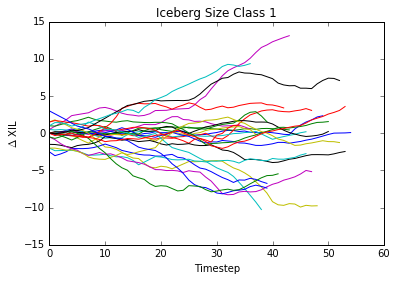

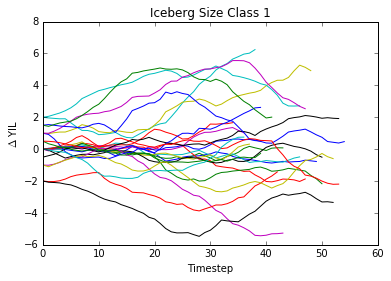

In [186]:
import matplotlib.pyplot as plt
%matplotlib inline

#XIL
plt.plot(dOut1XIL.transpose())
plt.xlabel('Timestep')
plt.ylabel('$\Delta$ XIL')
plt.title('Iceberg Size Class 1')
plt.show()

#YIL
plt.plot(dOut1YIL.transpose())
plt.xlabel('Timestep')
plt.ylabel('$\Delta$ YIL')
plt.title('Iceberg Size Class 1')
plt.show()